In [311]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn 

from tqdm import tqdm

In [312]:
data_imgs = np.load('../Kanji-recognizer/data/kkanj-imgs.npz')
data_labels = np.load('../Kanji-recognizer/data/kkanji-labels.npz')

imgs = data_imgs['arr_0']
labels = data_labels['arr_0']

def kanji(kaniUnicode):
    return chr(int(kaniUnicode[2:], 16))

X = imgs[:14000]
Z = labels[:14000]


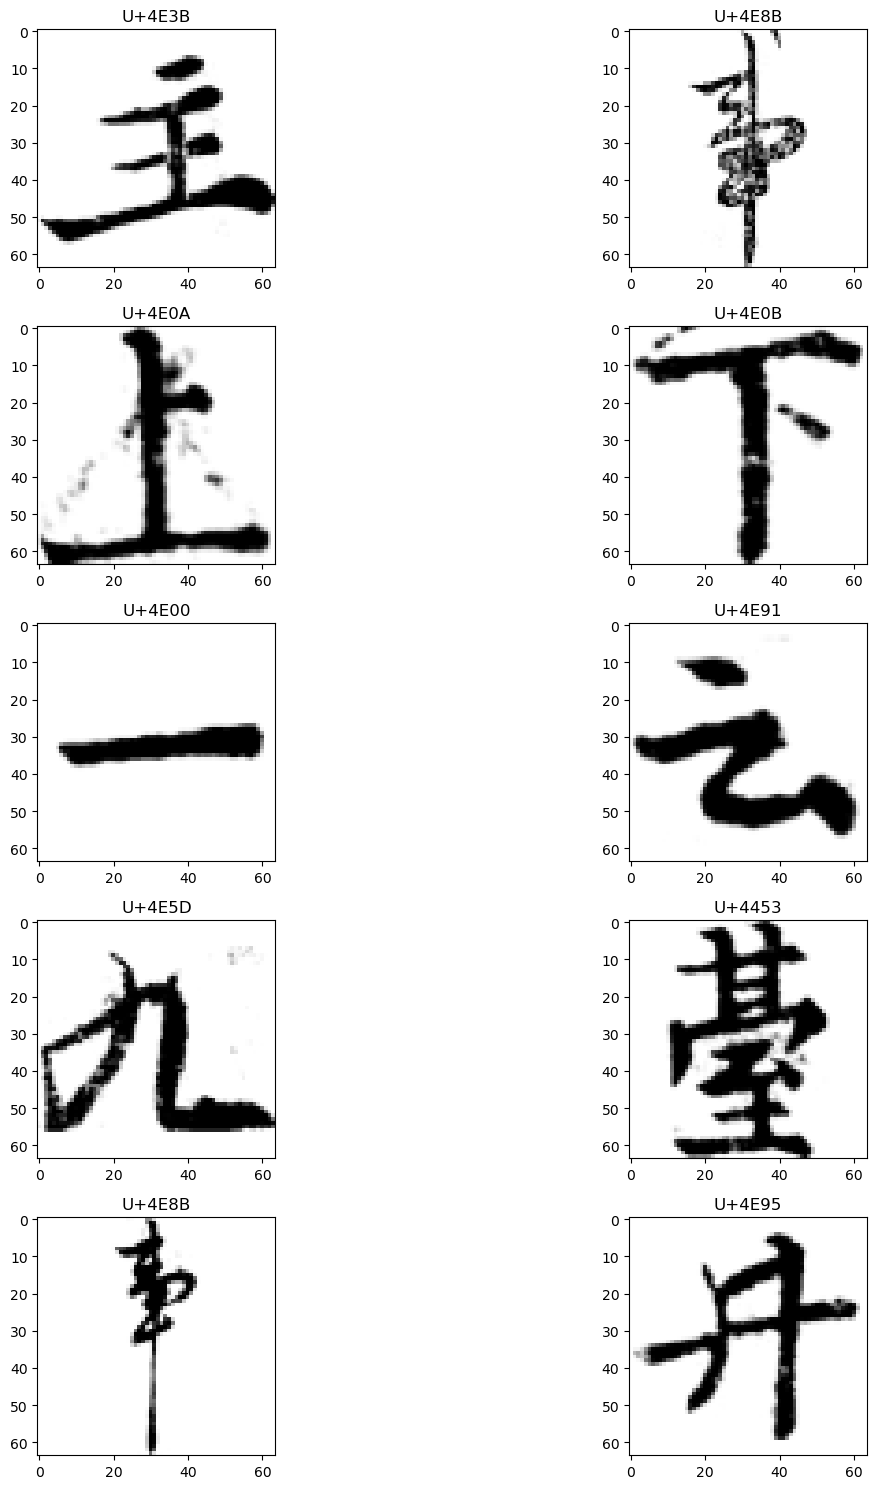

In [313]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap='Greys')
        ax[i,j].set_title(Z[l])
        
        
plt.tight_layout()

In [314]:
len(np.unique(Z))

79

In [315]:
le=LabelEncoder()


Y=le.fit_transform(Z)


Y=to_categorical(Y,len(np.unique(Z)))


X=np.array(X)


X=X/255


In [316]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [317]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding= 'Same', activation='relu', input_shape = (64,64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(79, activation="softmax"))

In [318]:
batch_size=200
epochs=5

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.1)

In [319]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

#datagen.fit(x_train.reshape(10500, 64, 64, 1))

In [320]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [321]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 96)        6240      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 96)        

In [322]:
History = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/5
52/52 [==============================] - 27s 507ms/step - loss: 1.8959 - accuracy: 0.5804 - val_loss: 0.8656 - val_accuracy: 0.7889
Epoch 2/5
52/52 [==============================] - 23s 441ms/step - loss: 0.6438 - accuracy: 0.8447 - val_loss: 0.4511 - val_accuracy: 0.8874
Epoch 3/5
52/52 [==============================] - 24s 461ms/step - loss: 0.3480 - accuracy: 0.9113 - val_loss: 0.3056 - val_accuracy: 0.9240
Epoch 4/5
52/52 [==============================] - 25s 475ms/step - loss: 0.2137 - accuracy: 0.9417 - val_loss: 0.2584 - val_accuracy: 0.9294
Epoch 5/5
52/52 [==============================] - 22s 431ms/step - loss: 0.1427 - accuracy: 0.9612 - val_loss: 0.2244 - val_accuracy: 0.9423


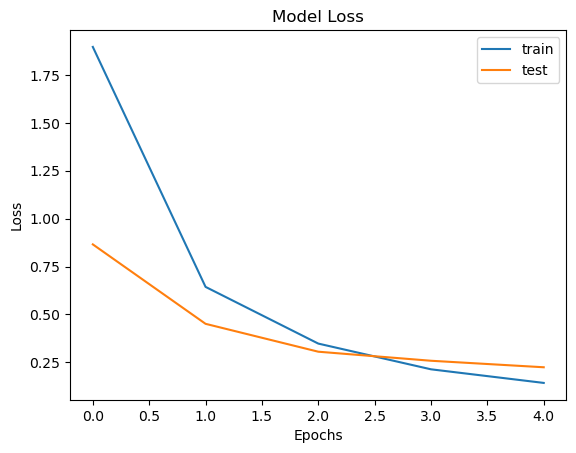

In [323]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [324]:
accuracy_history = [0]
accuracy_history_img = [0]

1/1 [==============================] - 0s 117ms/step
Predicted class: 32
Predicted class probability: 82.92185664176941 %


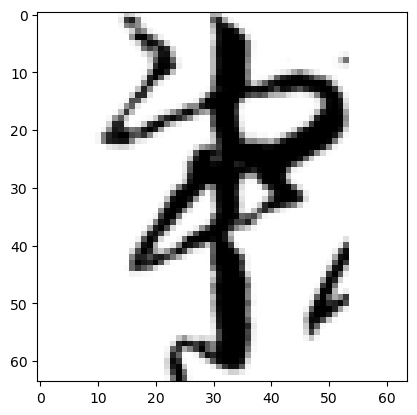

In [325]:
from matplotlib import pyplot


results = model.evaluate(x_test, y_test)
image_number = 378
new_image = tf.expand_dims(x_test[image_number], 0)
predictions = model.predict(new_image)
predicted_class_index = predictions.argmax(axis=-1)[0]
predicted_class_probability = predictions[0][predicted_class_index]
print('Predicted class:', predicted_class_index)
print('Predicted class probability:', predicted_class_probability*100, "%")

accuracy_history.append(predicted_class_probability*100)
accuracy_history_img.append(image_number)

pyplot.imshow(x_test[image_number], cmap='Greys')
#print(kanji(y_test[image_number]))


In [338]:
import webscraping

class_prediction = 30
print("Code: ", np.unique(Z)[class_prediction])
print(kanji(np.unique(Z)[class_prediction]))
webscraping.get_meaning(kanji(np.unique(Z)[class_prediction]))

Code:  U+4E21
両

both, 
old Japanese coin, 
counter for carriages (e.g., in a train), 
two



In [340]:
from matplotlib import pyplot
import random

accuracy_history = []
accuracy_history_img = []
predicted_class_index_list = [] 

for _ in range(100):
    image_number = random.randint(0, len(x_test) - 1)
    new_image = tf.expand_dims(x_test[image_number], 0)
    predictions = model.predict(new_image)
    predicted_class_index = predictions.argmax(axis=-1)[0]
    predicted_class_probability = predictions[0][predicted_class_index]
    print('Predicted class:', predicted_class_index)
    print('Predicted class probability:', predicted_class_probability * 100, "%")

    accuracy_history.append(predicted_class_probability * 100)
    accuracy_history_img.append(image_number)
    predicted_class_index_list.append(predicted_class_index)

    # pyplot.imshow(x_test[image_number], cmap='Greys')
    # pyplot.show()


1/1 [==============================] - 0s 52ms/step
Predicted class: 75
Predicted class probability: 99.70364570617676 %
1/1 [==============================] - 0s 40ms/step
Predicted class: 18
Predicted class probability: 95.52289843559265 %
1/1 [==============================] - 0s 91ms/step
Predicted class: 64
Predicted class probability: 78.12901735305786 %
1/1 [==============================] - 0s 63ms/step
Predicted class: 25
Predicted class probability: 99.97422099113464 %
1/1 [==============================] - 0s 45ms/step
Predicted class: 62
Predicted class probability: 53.9164662361145 %
1/1 [==============================] - 0s 37ms/step
Predicted class: 59
Predicted class probability: 99.86514449119568 %
1/1 [==============================] - 0s 39ms/step
Predicted class: 62
Predicted class probability: 99.99433755874634 %
1/1 [==============================] - 0s 37ms/step
Predicted class: 34
Predicted class probability: 93.83506178855896 %
1/1 [============================

[99.70364570617676, 95.52289843559265, 78.12901735305786, 99.97422099113464, 53.9164662361145, 99.86514449119568, 99.99433755874634, 93.83506178855896, 99.9887466430664, 99.99934434890747, 99.8989999294281, 87.70829439163208, 99.99994039535522, 99.66270923614502, 99.9286949634552, 97.21378684043884, 99.99998807907104, 99.98289346694946, 59.30192470550537, 91.50277972221375, 99.99696016311646, 99.70990419387817, 99.99998807907104, 82.50572681427002, 85.42677760124207, 99.8776376247406, 99.8005211353302, 99.99982118606567, 99.94803071022034, 98.8573670387268, 99.99969005584717, 94.21910047531128, 99.9936580657959, 94.08754110336304, 99.95352029800415, 100.0, 99.99983310699463, 96.91949486732483, 99.19724464416504, 99.9997615814209, 99.9157190322876, 99.99933242797852, 95.59864401817322, 99.99737739562988, 14.69716727733612, 99.99997615814209, 99.9464213848114, 99.9890923500061, 99.59633350372314, 99.66298937797546, 99.98258948326111, 70.94988226890564, 99.86409544944763, 99.9865889549255

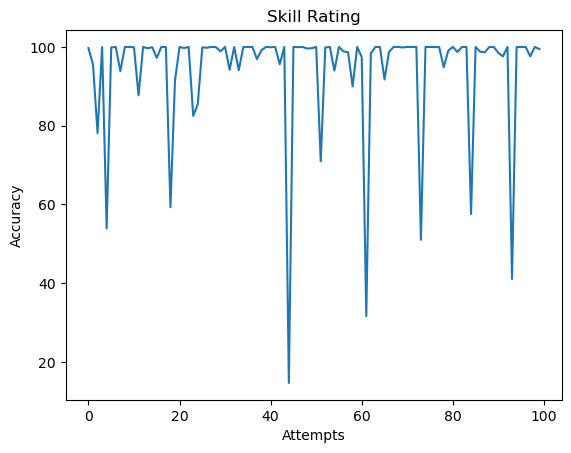

In [341]:

print(accuracy_history)
plt.plot(accuracy_history)
plt.title('Skill Rating')
plt.ylabel('Accuracy')
plt.xlabel('Attempts')
plt.show()

In [342]:
result = []
for a, b, c in zip(accuracy_history_img, accuracy_history, predicted_class_index_list):
    result.append((a, b, c))

for r in range(len(result)):
    image_number = result[r][0]
    accuracy = result[r][1]
    predicted_class_index = result[r][2]
    
    print("Element:", r+1)
    print("Image number:", image_number)
    print("Accuracy:", accuracy, "%")
    print("Predicted class index:", predicted_class_index)
    print()

average = sum(accuracy_history) / len(accuracy_history)
print("Average:", average, "%")

Element: 1
Image number: 1893
Accuracy: 99.70364570617676 %
Predicted class index: 75

Element: 2
Image number: 1554
Accuracy: 95.52289843559265 %
Predicted class index: 18

Element: 3
Image number: 1105
Accuracy: 78.12901735305786 %
Predicted class index: 64

Element: 4
Image number: 2621
Accuracy: 99.97422099113464 %
Predicted class index: 25

Element: 5
Image number: 2818
Accuracy: 53.9164662361145 %
Predicted class index: 62

Element: 6
Image number: 2281
Accuracy: 99.86514449119568 %
Predicted class index: 59

Element: 7
Image number: 899
Accuracy: 99.99433755874634 %
Predicted class index: 62

Element: 8
Image number: 2804
Accuracy: 93.83506178855896 %
Predicted class index: 34

Element: 9
Image number: 1328
Accuracy: 99.9887466430664 %
Predicted class index: 78

Element: 10
Image number: 3452
Accuracy: 99.99934434890747 %
Predicted class index: 62

Element: 11
Image number: 3147
Accuracy: 99.8989999294281 %
Predicted class index: 62

Element: 12
Image number: 3178
Accuracy: 87.7